In [37]:
import numpy as np
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss

In [38]:
# load raw financial data
raw_data = pd.read_csv('../../datasets/samples/stock_candle_timeseries_D.csv')
raw_data.head()

,timestamp,close_price,high-price,low-price,open_price,status,volume
0,1514851200,18.26,18.29,17.78,17.96,ok,2832725
1,1514937600,18.20,18.37,17.92,18.29,ok,3789189
2,1515024000,18.32,18.38,17.96,18.20,ok,2781341
3,1515110400,18.68,18.73,18.22,18.38,ok,3018989
4,1515369600,19.23,19.40,18.80,18.80,ok,3668401


## Data Preprocessing

In [39]:
# create train dataset
# sorted based on timestamp 

# extract timestamps for visualization
timestamp_list = list(raw_data['timestamp'])
datetime_list = [datetime.fromtimestamp(ts) for ts in timestamp_list]

# select feature columns for training and predictions
df = raw_data.drop(['status','timestamp'],axis=1)

# create a list of column names for training and predictions
cols = list(df)
# reordering the columns: put the prediction column to the last column
cols = ['open_price', 'high-price', 'low-price', 'volume','close_price']
# cols = ['open_price', 'high-price', 'low-price','close_price']
df = df[cols]

# check the df column types to ensure they have correct types
print(df.dtypes)
cols



open_price     float64
high-price     float64
low-price      float64
volume           int64
close_price    float64
dtype: object


['open_price', 'high-price', 'low-price', 'volume', 'close_price']

In [40]:
# finding missing values
df.isnull().sum()

open_price     0
high-price     0
low-price      0
volume         0
close_price    0
dtype: int64

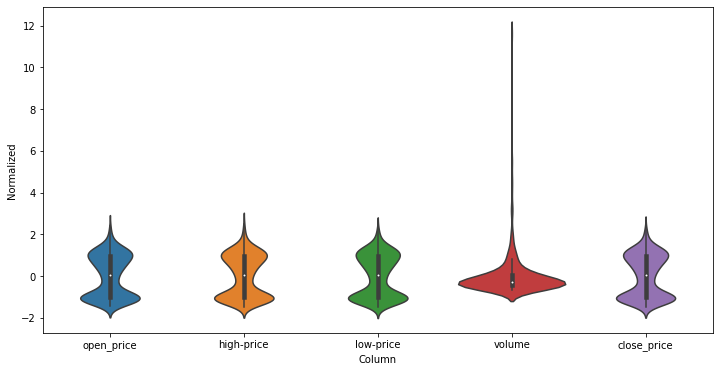

In [41]:
# Visualize the ditribution of the features in the train dataset
df_std = (df - df.mean()) / df.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [42]:
# scale / normalize the dataset
sc = StandardScaler()
df_scaled = sc.fit_transform(df)

# scaling true value of prediction column
sc_prediction = StandardScaler() 
prediction_set_scaled = sc_prediction.fit_transform(df['close_price'].to_numpy().reshape(-1,1))

df_size = df_scaled.shape[0]

# keep last 30 days of data as test set 
# split the data to train, validate and test
n = len(df_scaled)

train_df = df_scaled[:int(n*0.7)]
val_df = df_scaled[int(n*0.7):int(n*0.9)]
test_df = df_scaled[int(n*0.9):]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(529, 5)
(151, 5)
(76, 5)


### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [43]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, train_step):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window -1):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window:i+train_window+train_step, -1]
        x_arr.append(x)
        y_arr.append(y)
        dataset_seq.append((x, y))
    return np.array(x_arr), np.array(y_arr)

# let's create sewquential training dataset with traning window = 30 days and train step = 1 day
# given that the financial data timestep is 5 minutes 
# train_window = 30*24*3600*15    
# train_step = 1*24*3600*15
# given 1 day resolution
train_window = 30
train_step = 1

X_train, y_train = generate_window(train_df, train_window, train_step)
X_val, y_val = generate_window(val_df, train_window, train_step)
X_test, y_test = generate_window(test_df, train_window, train_step)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

num_features = X_train.shape[2]

torch.Size([498, 30, 4])
torch.Size([498, 1])
torch.Size([120, 30, 4])
torch.Size([120, 1])


## Creating LSTM Network

In [44]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers = 2, output_size=1, seq_length=30):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden = None

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
        cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x, forecast_timesteps = 0):
        batch_size = x.shape[0]
        if self.hidden is None:
            self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        
        outputs = self.linear(lstm_out.reshape(batch_size,-1))

        return outputs


## Traning LSTM model

In [45]:
num_epochs = 100
learning_rate = 5e-4

history = dict(train=[], val=[])
# create a LSTM model with default args defined above
model = LSTM(seq_length=train_window, input_size=num_features)
print(model.input_size)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

4


In [46]:
# best_model_wts = copy.deepcopy(model.state_dict())
best_loss = np.Inf

# Train the model
for epoch in range(num_epochs):
    model.train()
    X_train.to(device)
    model.init_hidden(X_train.shape[0])
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    train_loss = loss.item()

    with torch.no_grad():
        model.eval()
        X_val.to(device)
        model.init_hidden(X_val.shape[0])
        pred = model(X_val)
        loss = criterion(pred, y_val)
        val_loss = loss.item()

    history['val'].append(val_loss)
    history['train'].append(train_loss)
   

    if val_loss < best_loss:
        best_loss = val_loss
        # best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

# model.load_state_dict(best_model_wts)


Epoch 0: train loss 0.8426696062088013 val loss 1.2191423177719116
Epoch 1: train loss 0.8016180992126465 val loss 1.2187062501907349
Epoch 2: train loss 0.7618303894996643 val loss 1.204767107963562
Epoch 3: train loss 0.7195953130722046 val loss 1.1749122142791748
Epoch 4: train loss 0.6745784878730774 val loss 1.126866102218628
Epoch 5: train loss 0.6244827508926392 val loss 1.056783676147461
Epoch 6: train loss 0.5689881443977356 val loss 0.9617146849632263
Epoch 7: train loss 0.5077041387557983 val loss 0.8410317301750183
Epoch 8: train loss 0.43983373045921326 val loss 0.6970834136009216
Epoch 9: train loss 0.3656104803085327 val loss 0.5355783104896545
Epoch 10: train loss 0.2894611656665802 val loss 0.36694100499153137
Epoch 11: train loss 0.21282519400119781 val loss 0.20828686654567719
Epoch 12: train loss 0.14343523979187012 val loss 0.08607585728168488
Epoch 13: train loss 0.09080062806606293 val loss 0.037282343953847885
Epoch 14: train loss 0.06578653305768967 val loss 0.

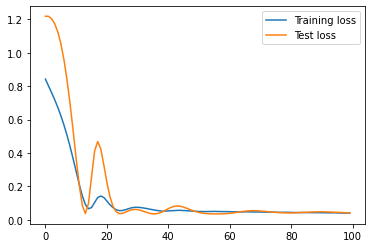

In [47]:

plt.plot(history['train'], label="Training loss")
plt.plot(history['val'], label="Test loss")
plt.legend()

## Predictions

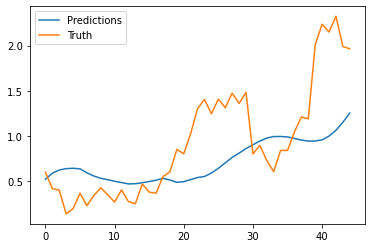

In [48]:
# model(X_test)
predictions, losses = [], []
criterion = nn.L1Loss(reduction='sum').to(device)

with torch.no_grad():
    model.eval()
    for i in range(X_test.shape[0]):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        model.init_hidden(x_i.shape[0])
        y_pred = model(x_i)
        predictions.append(y_pred.cpu().numpy().flatten())
        loss = criterion(y_pred, y_i)
        losses.append(loss.item())

# sns.distplot(losses, bins=50, kde=True)
plt.plot(predictions, label="Predictions")
plt.plot(y_test, label="Truth")
plt.legend()